In [1]:
# encoding=utf8  
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import scipy.interpolate
import scipy.optimize
import sys
import math
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import Divider, Size
#from ipywidgets import interact

def CW(T, C, th): #curie weiss fit
	return C/(T-th)
def CW_lam(T, C, th,lam): #curie weiss fit + constant offset
	return C/(T-th)+lam
def CW_lam_par(T, C, th,lam,C2): #curie weiss fit + constant offset + paramagnetism
	return C/(T-th)+lam+C2/T

In [2]:
def coth(x):
  return 1/np.tanh(x)
def raw_datafile_2_chi(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data = data[np.argsort(data[:, 3])] # sort all data by temperature
    time = data[:,0] #in s
    fields = data[:,2] # in Oe
    T = data[:,3] # in K
    M = data[:,4] # in emu
    M_err = data[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field = fields[0] #Oersted
    
    chi = M/field * molar_mass / mass + dia
    chi_err = M_err/field * molar_mass / mass
    return T,chi,chi_err

def raw_datafile_2_chi_ZFC(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data_ZFC = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data_ZFC = data_ZFC[np.argsort(data_ZFC[:, 3])] # sort data by temperature
    time = data_ZFC[:,0] #in s
    fields_ZFC = data_ZFC[:,2] # in Oe
    T_ZFC = data_ZFC[:,3] # in K
    M_ZFC = data_ZFC[:,4] # in emu
    M_err_ZFC = data_ZFC[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field_ZFC = fields_ZFC[0] #Oersted
    
    chi_ZFC = M_ZFC/field_ZFC * molar_mass / mass + dia
    chi_err_ZFC = M_err_ZFC/field_ZFC * molar_mass / mass
    return T_ZFC,chi_ZFC,chi_err_ZFC
    
def raw_datafile_2_chi_FC(data_file,molar_mass,mass,dia):
    head_len = 31 # lines in the header
    #data_file = "CsMnNCS3_ZFC_field_zocefa.rso.dat" # name of the data file
    data_FC = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data_FC = data_FC[np.argsort(data_FC[:, 3])] # sort data by temperature
    time_FC = data_FC[:,0] #in s
    fields_FC = data_FC[:,2] # in Oe
    T_FC = data_FC[:,3] # in K
    M_FC = data_FC[:,4] # in emu
    M_err_FC = data_FC[:,5] # in emu

    #molar_mass = 362.09#g mol-1
    #mass = 9.6 *1e-3 #mg
    #dia = 100*1e-6 # 1e-6 emu mol-1 #need to calculate
    field_FC = fields_FC[0] #Oersted

    chi_FC = M_FC/field_FC * molar_mass / mass + dia
    chi_err_FC = M_err_FC/field_FC * molar_mass / mass
    return T_FC,chi_FC,chi_err_FC

def raw_datafile_2_AC(data_file,molar_mass,mass):
    import numpy as np
    head_len = 28
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',') 
    data = data[np.argsort(data[:, 3],kind='stable')] #sort by T
    data = data[np.argsort(data[:, 14],kind='stable')] #sort by freq

    T = data[:,3]
    T = T.round(decimals=1) # to make sure the Temperatures are identical at the same point
    amp = data[:,8] #|m| (emu)
    s_amp = data[:,9]
    phase = data[:,10] #phase of m (deg)
    s_phase = data[:,11]
    reg_fit = data[:,12] #regression fit
    field = 1000 #Oe
    driver = data[0,13] #driver amplitude (Oe)
    freq = data[:,14] #Hz
    freq_list = np.unique(freq)
    T_list = np.unique(T)
    m = data[:,4]/(driver) * molar_mass / mass #m' in emu Oe-1 mol-1
    s_m = data[:,5]/driver * molar_mass / mass #sigma m'in emu Oe-1 mol-1
    md = data[:,6]/driver * molar_mass / mass # m''in emu Oe-1 mol-1
    s_md = data[:,7]/driver * molar_mass / mass #sigma m''in emu Oe-1 mol-1
    return freq,freq_list,T,T_list,m,s_m,md,s_md

def raw_datafile_2_MH(data_file,molar_mass,mass,dia):
    head_len=31
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',')

    Oe = 1e4 #unit conversion
    muB = 9.27401e-21 * 6.022140e23

    time = data[:,1] #in s
    field = data[:,2] # in Oe
    T = data[0,2] # in K
    M = data[:,4] # in emu
    M_err = data[:,5] # in emu
    
    H =  field / Oe   
    conv =  molar_mass / mass #* 1e-3 / muB
    M = M*conv
    BMM = M / muB
    return H,M,BMM

def raw_datafile_2_MH_err(data_file,molar_mass,mass,dia):
    head_len=31
    data = np.genfromtxt(data_file,skip_header=head_len,delimiter=',')

    Oe = 1e4 #unit conversion
    muB = 9.27401e-21 * 6.022140e23

    time = data[:,1] #in s
    field = data[:,2] # in Oe
    T = data[0,2] # in K
    M = data[:,4] # in emu
    M_err = data[:,5] # in emu
    
    H =  field / Oe   
    conv =  molar_mass / mass #* 1e-3 / muB
    M_err = M_err*conv
    BMM_err = M_err / muB
    return M_err,BMM_err

def datafile_2_MH(data_file):
    head_len=4
    data = np.genfromtxt(data_file,skip_header=head_len)
    Oe = 1e4
    H =  np.array(data[:,0]) / Oe   

    fh = open(data_file,'r')
    param = np.zeros(head_len)
    for i,line in enumerate(fh):
    	if i is head_len: break
    	param[i]= line
    fh.close()

    molar_mass = param [0] #g mol-1
    mass = param [1]*1e-3 #mg
    dia = param [2]*1e-6 # 1e-6 emu mol-1
    T =  param[3] #K
    muB = 9.27401e-21 * 6.022140e23

    conv =  molar_mass / mass #* 1e-3 / muB
    M = data[:,1]*conv
    BMM = M / muB
    return H,M,BMM

def B_s(S,y): #Brillouin function, diff. to Johnston
    return (2.0*S+1.0)/(2.0*S)*coth((2.0*S+1.0)/(2.0*S)*y)-coth(y/(2.0*S))/(2.0*S)
#y = g_J * muB * J * B  /kT

def lang(y): #Langevin
    return coth(y)-1/y


def mu_lin(T,S,lam,g,y):
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    return k_b*T*y/(g*mu_b *S*lam)

def mu0_det(y,T,S,lam,g,Ms):    
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    return (B_s(S,y)*Ms-mu_lin(T,S,lam,g,y))**2

def mu0(S,ts):
    out = np.zeros_like(ts)
    i=0
    for t in ts:
        out[i] = scipy.optimize.minimize_scalar(mu0_det,args=(S,t), tol=None, options=None).get('x') #    method='bounded',bounds=(0,1)
        i=i+1
    return out

def brillouin_T(Ts,S,lam,g,Ms): #brillouin function of moment as a function of T
    #S = spin
    #lam = molecular field
    #g = g-value
    #Ms = saturation moment
    k_b = 1.3806488e-23
    mu_b = 9.27400e-24 #SI value
    y = np.zeros_like(Ts)
    M_out = np.zeros_like(Ts)
    test = np.zeros_like(Ts)  
    test2 = np.zeros_like(Ts)      
    i=0
    for t in Ts:
        fit = scipy.optimize.minimize(mu0_det,args=(t,S,lam,g,Ms), #method='bounded',bounds=(0,1),
     tol=None, x0=(1000))
        y[i] =fit.get('x') #determine y
        M_out[i] = B_s(S,y[i])*Ms
       # test[i] = (k_b*t*y[i])/(g*mu_b*S*lam)
       # test2[i]  =mu0_det(t,S,lam,g,Ms,y[i])#k_b * t * y[i]/(g*mu_b*S*lam)
        i=i+1       
    return M_out
#def brillouin_T(Ts,S,lam,g,Ms):


In [3]:
#Diamagnetic Contributions

#Sample
molar_mass = 206.84#g mol-1 #####
mass = 4.5 *1e-3 #g ####
sample_dia = 111.8*1e-6 # 1e-6 emu mol-1 

#Eicosane
eicosane_molar_mass = 282.55 #g mol-1 ####
eicosane_mass = 5.9 *1e-3 #mg ####
eicosane_molar_dia = 243.06*1e-6 # 1e-6 emu mol-1 

#Diamagnetic contribution of eicosane per mole of sample
eicosane_dia = (((eicosane_mass)/eicosane_molar_mass)*eicosane_molar_dia)/(mass/molar_mass)

dia = sample_dia + eicosane_dia # 1e-6 emu mol-1 

<IPython.core.display.Javascript object>


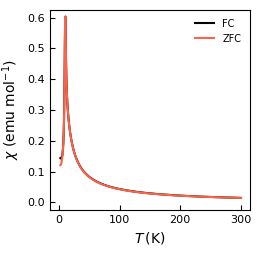

In [4]:
fig = plt.figure(1, figsize=(2.6, 2.6))
h = [Size.Fixed(0.5), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

T_FC,chi_FC,chi_err_FC=raw_datafile_2_chi_FC("FeCl2pym_2-300K_FC.rso.dat",molar_mass,mass,dia)
plt.plot(T_FC,chi_FC,label='FC',c='black')

T_ZFC,chi_ZFC,chi_err_ZFC=raw_datafile_2_chi("FeCl2pym_2-300K_ZFC.rso.dat",molar_mass,mass,dia)
plt.plot(T_ZFC,chi_ZFC,label='ZFC',c='tomato')

plt.legend(shadow=False, loc=1,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('$\\chi$ (emu mol$^{-1}$)')
#plt.tight_layout()
plt.xlim(-15,315)
plt.ylim(-0.025,0.625)
#plt.xscale('log')

#ax1.axis('square')

#plt.savefig('FeCl2pym_muciwe2_chi_ZFC_FC.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('Cr(pym)Cl$_2$_chi_ZFC_FC_0-50.png',dpi=750)

plt.show()

<IPython.core.display.Javascript object>


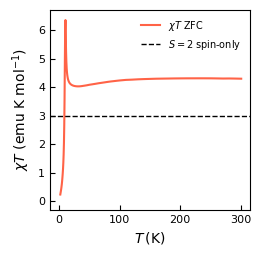

In [5]:
fig = plt.figure(3, figsize=(2.6, 2.6))
h = [Size.Fixed(0.5), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

T_ZFC,chi_ZFC,chi_err_ZFC=raw_datafile_2_chi_ZFC("FeCl2pym_2-300K_ZFC.rso.dat",molar_mass,mass,dia)
plt.plot(T_ZFC,chi_ZFC*T_ZFC,color='tomato',label='$\\chi T$ ZFC ')#,s=30)

T_FC,chi_FC,chi_err_FC=raw_datafile_2_chi_FC("FeCl2pym_2-300K_FC.rso.dat",molar_mass,mass,dia)

plt.xlim(-15,315)
plt.ylim(-0.3,6.7)
plt.axhline(3,0,1, label="$S=2$ spin-only", color='k', lw=1, ls='dashed')

plt.legend(shadow=False,loc=1,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('$\\chi T$ (emu K mol$^{-1}$)')
#plt.savefig('FeCl2pym_muciwe2_chiT.pdf',bbox_inches='tight', transparent=True)
plt.show()

In [6]:
chiT_hi = 1.82 #high temperature value of chiT, i.e. S(S+1)/2
mueff = (chiT_hi*8)**0.5 #the mu_eff moment should be just gsqrt(S(S+1)) by spin only approximation and high temperature assumption that Curie law is obeyed
print(mueff) # significnatly reduced value

2*(1.5*2.5)**0.5

3.8157568056677826


3.872983346207417

57 50.04052
[ 4.37994304 -3.73422994]
[[ 2.76403499e-05 -4.38954121e-04]
 [-4.38954121e-04  7.87059698e-03]]
C 4.379943038213448 ( 0.005257409044679966 )
BM 5.919420943446038 ( 0.2050835740800314 )
Weiss T -3.734229936442609 ( 0.08871638508670669 )
g 2.4161160101470998 ( 0.08370847613085783 )


<IPython.core.display.Javascript object>


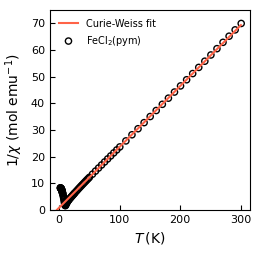

In [7]:
#Curie Weiss fitting 
T,chi,chi_err=raw_datafile_2_chi("FeCl2pym_2-300K_ZFC.rso.dat",molar_mass,mass,dia)
start = np.argmax(T>50) #this number here determines where the CW fit starts
print (start,T[start])

p0 = (3,-60)

popt, pcov = scipy.optimize.curve_fit(CW, T[start:], chi[start:],sigma=chi_err[start:],p0=p0)
print (popt)
print (pcov)
print ('C', (popt[0]),'(',pcov[0,0]**0.5,')')
print ('BM', (popt[0]*8)**0.5,'(',(8*pcov[0,0]**0.5)**0.5,')')
print ('Weiss T', (popt[1]),'(',pcov[1,1]**0.5,')')

J=2
mu_0 = 1.256637062*1e-6
mu_b = 9.274010*1e-21
k_b = 1.38064852*1e-16
N_a = 6.0221409*1e+23
C=popt[0]

g = np.sqrt(C*(3*k_b)/(N_a*mu_b*mu_b*J*(J+1)))
#g_err = g*0.5*(pcov[0,0]**0.5)/C
g_err = np.sqrt(pcov[0,0]**0.5*(3*k_b)/(N_a*mu_b*mu_b*J*(J+1)))
print("g",g,'(',g_err,')')

#1/chi plot
fig = plt.figure(400, figsize=(2.6, 2.6))
h = [Size.Fixed(0.5), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

T_range = np.arange(0.01,300,0.01)

m, c = np.polyfit(T, 1/CW(T,*popt), 1)

x=np.arange(-60,305,5)

plt.plot(x, m*x + c, color='tomato', label='Curie-Weiss fit')


plt.scatter(T,1.0/(chi),label='FeCl$_2$(pym)', marker="o", edgecolor="black", facecolor='none', s=20)
#plt.plot(T,1/CW(T,*popt),color='tomato',label='Curie-Weiss fit')

plt.xlim(-15,315)#plt.xlim(0,300)
plt.ylim(0,75)#plt.xlim(0,300)

plt.legend(shadow=False, loc=2,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('1/$\\chi$ (mol emu$^{-1}$)')
#plt.savefig('Cr(pym)Cl$_2$_Curie-Weiss_fit_ZFC.png',dpi=750)

plt.show()

67 100.1699
[ 4.34888381 -2.4175959 ]
[[ 4.20186178e-05 -1.41342494e-03]
 [-1.41342494e-03  5.33483993e-02]]
BM 5.898395585570036 ( 0.22772223313381995 )
Weiss T -2.4175958971864433 ( 0.23097272404938127 )


<IPython.core.display.Javascript object>


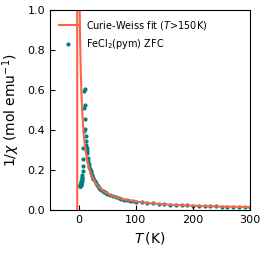

4.348883810484011 -2.4175958971864433


In [8]:
#Curie Weiss fitting 
T,chi,chi_err=raw_datafile_2_chi("FeCl2pym_2-300K_ZFC.rso.dat",molar_mass,mass,dia)
start = np.argmax(T>100) #this number here determines where the CW fit starts
print (start,T[start])

p0 = (3,-60)

popt, pcov = scipy.optimize.curve_fit(CW, T[start:], chi[start:],sigma=chi_err[start:],p0=p0)
print (popt)
print (pcov)
print ('BM', (popt[0]*8)**0.5,'(',(8*pcov[0,0]**0.5)**0.5,')')
print ('Weiss T', (popt[1]),'(',pcov[1,1]**0.5,')')
#1/chi plot
fig = plt.figure(4, figsize=(2.6, 2.6))
h = [Size.Fixed(0.5), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")
T_range = np.arange(-60,300,0.01)

#m, c = np.polyfit(T, 1/CW(T,*popt), 1)

plt.plot(T_range, CW(T_range,*popt), color='tomato', label='Curie-Weiss fit ($T$>150K)')


plt.scatter(T,(chi),color='teal',label='FeCl$_2$(pym) ZFC', s=4)
#plt.plot(T,1/CW(T,*popt),color='tomato',label='Curie-Weiss fit')

plt.xlim(-50,300)#plt.xlim(0,300)
plt.ylim(0,1)#plt.xlim(0,300)

plt.legend(shadow=False,loc=2,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('1/$\\chi$ (mol emu$^{-1}$)')
#plt.savefig('Cr(pym)Cl$_2$_Curie-Weiss_fit_ZFC.png',dpi=750)

plt.show()

print(*popt)

<IPython.core.display.Javascript object>


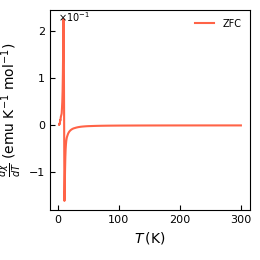

[ 0.1738479   0.01552939 -0.16035475] [10.00499 10.51201 11.01904]
TN 10.556777339180492
TN_err 0.0004508175565072457


In [9]:
fig = plt.figure(22, figsize=(2.6, 2.6))
h = [Size.Fixed(0.5), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

T_range = np.arange(0.01,300,0.01)

dXdT=(chi[1:]-chi[:-1])/(T[1:]-T[:-1])
Td=T[1:]
start = np.argmax(Td>9.9)
finish = np.argmax(Td>11.2)
print(dXdT[start:finish], Td[start:finish])
f = scipy.interpolate.interp1d(dXdT[start:finish], Td[start:finish])
print("TN",f(0))

f_err = scipy.interpolate.interp1d(dXdT[start:finish], chi_err[start:finish])
print("TN_err",f_err(0))

plt.plot(T[1:],10*(chi[1:]-chi[:-1])/(T[1:]-T[:-1]),color='tomato',label='ZFC')#, s=4)

ax1.text(1, 2.2,"$\\times 10^{-1}$",fontsize=7)

plt.legend(shadow=False, loc=1,frameon=False)
plt.xlabel('$T\\,$(K)')
plt.ylabel('$\\frac{d \\chi}{dT}$ (emu K$^{-1}$ mol$^{-1}$)')
plt.show()
#plt.savefig('dXdT_FepymCl2_muciwe_zoom.pdf',bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>


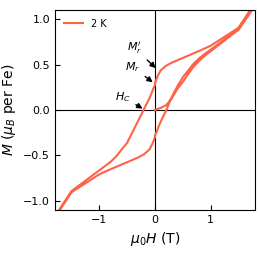

[0.3130204  0.29385816 0.27659221 0.26277721]
[ 1.007451e-02  2.212558e-05  2.317918e-05 -1.007978e-02]
Hc -0.20606181732717643
Hc_err 0.003998440708914648
Mrem 0.29385815931273485 ( 0.003714694618133788 )


In [12]:
H2K,M2K,BMM2K = raw_datafile_2_MH("FeCl2pym_MH.rso.dat",molar_mass,mass,dia)
M2K_err,BMM2K_err = raw_datafile_2_MH_err("FeCl2pym_MH.rso.dat",molar_mass,mass,dia)

fig = plt.figure(5, figsize=(2.6, 2.6))
h = [Size.Fixed(0.55), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

plt.axvline(0,0,1,  color='k', lw=0.8)
plt.axhline(0,0,1,  color='k', lw=0.8)

H2K = ma.array(H2K)
H2K[124]=ma.masked
H2K=H2K.compressed()

BMM2K = ma.array(BMM2K)
BMM2K[124]=ma.masked
BMM2K=BMM2K.compressed()


f = scipy.interpolate.interp1d(BMM2K[55:70], H2K[55:70])
#print(len(H2K))
print(BMM2K[54:58])
print(H2K[54:58])
print("Hc",f(0))

BMM2K_err = ma.array(BMM2K_err)
BMM2K_err[124]=ma.masked
BMM2K_err=BMM2K_err.compressed()

f_err = scipy.interpolate.interp1d(BMM2K[55:70], BMM2K_err[55:70])
print("Hc_err",f_err(0))

print("Mrem", BMM2K[55], '(', BMM2K_err[55], ')')

ax1.plot(H2K,BMM2K,color='tomato',label='2 K')
ax1.legend(frameon=False,loc=2)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$M$ ($\\mu_B$ per Fe)')
ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.1,1.1)
ax1.annotate("$M^\prime_r$", (0.05,0.44), xytext=(-0.5,0.65), xycoords='data', arrowprops=dict(facecolor='k',arrowstyle="-|>", connectionstyle="arc3"),fontsize=8)
ax1.annotate("$M_r$", (0.5,0.63), xytext=(0.35,0.7), xycoords='axes fraction', arrowprops=dict(facecolor='k',arrowstyle="-|>", connectionstyle="arc3"),fontsize=8)
ax1.annotate("$H_C$", (0.45,0.5), xytext=(0.3,0.55), xycoords='axes fraction', arrowprops=dict(facecolor='k',arrowstyle="-|>", connectionstyle="arc3"),fontsize=8)

#plt.savefig('MH_FepymCl2_muciwe.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


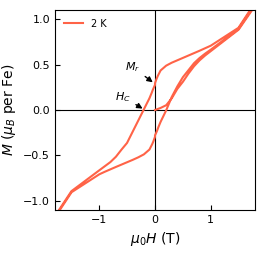

[0.3130204  0.29385816 0.27659221 0.26277721]
[ 1.007451e-02  2.212558e-05  2.317918e-05 -1.007978e-02]
Hc -0.20606181732717643
Hc_err 0.003998440708914648
Mrem 0.29385815931273485 ( 0.003714694618133788 )


In [13]:
H2K,M2K,BMM2K = raw_datafile_2_MH("FeCl2pym_MH.rso.dat",molar_mass,mass,dia)
M2K_err,BMM2K_err = raw_datafile_2_MH_err("FeCl2pym_MH.rso.dat",molar_mass,mass,dia)

fig = plt.figure(50, figsize=(2.6, 2.6))
h = [Size.Fixed(0.55), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

plt.axvline(0,0,1,  color='k', lw=0.8)
plt.axhline(0,0,1,  color='k', lw=0.8)

H2K = ma.array(H2K)
H2K[124]=ma.masked
H2K=H2K.compressed()

BMM2K = ma.array(BMM2K)
BMM2K[124]=ma.masked
BMM2K=BMM2K.compressed()


f = scipy.interpolate.interp1d(BMM2K[55:70], H2K[55:70])
#print(len(H2K))
print(BMM2K[54:58])
print(H2K[54:58])
print("Hc",f(0))

BMM2K_err = ma.array(BMM2K_err)
BMM2K_err[124]=ma.masked
BMM2K_err=BMM2K_err.compressed()

f_err = scipy.interpolate.interp1d(BMM2K[55:70], BMM2K_err[55:70])
#print(BMM2K_err[55:70])
print("Hc_err",f_err(0))

print("Mrem", BMM2K[55], '(', BMM2K_err[55], ')')

ax1.plot(H2K,BMM2K,color='tomato',label='2 K')

ax1.legend(frameon=False,loc=2)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$M$ ($\\mu_B$ per Fe)')

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.1,1.1)
ax1.annotate("$M_r$", (0.5,0.63), xytext=(0.35,0.7), xycoords='axes fraction', arrowprops=dict(facecolor='k',arrowstyle="-|>", connectionstyle="arc3"),fontsize=8)
ax1.annotate("$H_C$", (0.45,0.5), xytext=(0.3,0.55), xycoords='axes fraction', arrowprops=dict(facecolor='k',arrowstyle="-|>", connectionstyle="arc3"),fontsize=8)

#plt.savefig('MH_FepymCl2_muciwe.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('MH_FepymCl2_muciwe_zoom.pdf',bbox_inches='tight', transparent=True)
plt.show()


<IPython.core.display.Javascript object>


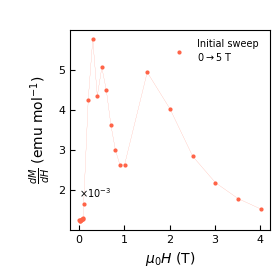

In [14]:
H2K,M2K,BMM2K = raw_datafile_2_MH("FeCl2pym_MH.rso.dat",molar_mass,mass,dia)

fig = plt.figure(6, figsize=(2.8,2.8))
h = [Size.Fixed(0.7), Size.Fixed(2)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

#ax1.plot(H2K,BMM2K,color='indigo',label='2 K')

top=np.argmax(H2K)
H2K=H2K[:top]
M2K=M2K[:top]

plt.scatter(H2K[:-1],(M2K[1:]-M2K[:-1])/(H2K[1:]-H2K[:-1])*1e-3,color='tomato',label='Initial sweep \n$0\\rightarrow 5$ T', s=4)
plt.plot(H2K[:-1],(M2K[1:]-M2K[:-1])/(H2K[1:]-H2K[:-1])*1e-3,color='tomato',linewidth=0.1)
#ax1.text(-5, 6.4, '$\\times 10^2$',fontsize=7)#

#ax1.text(-0.05, 6,"$\\times 10^{-3}$",fontsize=7)
ax1.text(-0.004, 1.82,"$\\times 10^{-3}$",fontsize=7)


ax1.legend(frameon=False,loc=1)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$\\frac{dM}{dH}$ (emu mol$^{-1}$)')

#plt.savefig('dMdH_FeCl2pym_muciwe2.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('dMdH_FeCl2pym_muciwe2_zoom.pdf',bbox_inches='tight', transparent=True)
plt.show()

<IPython.core.display.Javascript object>


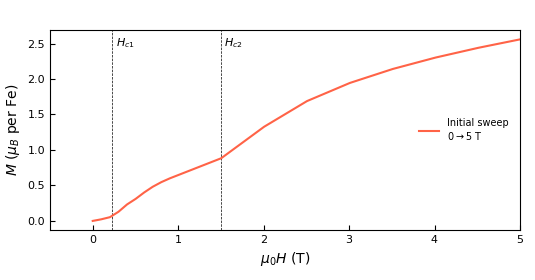

In [15]:
H2K,M2K,BMM2K = raw_datafile_2_MH("FeCl2pym_MH.rso.dat",molar_mass,mass,dia)

fig = plt.figure(7, figsize=(5.35,2.8))
h = [Size.Fixed(0.5), Size.Fixed(4.7)]
v = [Size.Fixed(0.5), Size.Fixed(2)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax1 = fig.add_axes(divider.get_position(),axes_locator=divider.new_locator(nx=1, ny=1))
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 7
ax1.tick_params(axis='both', labelsize=8, direction="in")

top=np.argmax(H2K)
top=top+1
H2K=H2K[:top]
M2K=M2K[:top]
BMM2K=BMM2K[:top]

plt.plot(H2K,BMM2K,color='tomato',label='Initial sweep \n$0\\rightarrow 5$ T')

plt.axvline(0.223,zorder=0,c="k", ls="--",lw=0.5)
plt.axvline(1.5,zorder=0,c="k", ls="--",lw=0.5)

ax1.annotate("$H_{c1}$", (0.14,0.92), xytext=None, xycoords='axes fraction', arrowprops=None,fontsize=8)
ax1.annotate("$H_{c2}$", (0.37,0.92), xytext=None, xycoords='axes fraction', arrowprops=None,fontsize=8)



ax1.legend(frameon=False,loc=7)
ax1.set_xlabel('$\\mu_0H$ (T)')
ax1.set_ylabel('$M$ ($\\mu_B$ per Fe)')
ax1.set_xlim(-0.5,5)
#plt.savefig('MH_FeCl2pym_muciwe2_phase_diagram.pdf',bbox_inches='tight', transparent=True)
#plt.savefig('dMdH_FeCl2pym_muciwe2_zoom.pdf',bbox_inches='tight', transparent=True)
plt.show()